This is a quick example of how these forecasts could be implemented:

In [1]:
import pandas as pd
import os
from pv_model import model_pv_power
from forecast_solar import get_solar_forecast_fast, get_solar_forecast_ensemble
import matplotlib.pyplot as plt

Import specs:

In [2]:
folder = 'output_specs' 
filename = 'agg_specs_orig_df.pkl'
file_to_read = os.path.join(folder, filename)
agg_specs_orig_df = pd.read_pickle(file_to_read)
agg_specs_orig_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
latitude,32.811041,31.719983,33.021601,31.888,31.255,33.404486,30.4214,28.883196,31.435932,31.030996,32.104125,33.467803,32.4744,32.460054,32.533273,34.380532,26.090103,33.261505,29.271667,29.242304
longitude,-99.91749,-104.442292,-99.61463,-100.825,-102.272,-96.082472,-97.4614,-99.178605,-99.796613,-102.488209,-100.162375,-95.370856,-95.7156,-102.672809,-96.428985,-100.099625,-97.798453,-97.238057,-98.444722,-95.658144
nameplate_dc,131.5944,256.362179,94.507156,130.434783,234.0,170.854369,186.0,176.0,319.0,172.362353,143.08,260.0,82.098305,133.931,182.009816,165.306333,184.861111,191.275636,53.936118,162.4
nameplate_ac,100.8,188.2,74.9,100.0,180.0,125.7,144.0,132.4,250.0,126.3,102.2,198.5,59.8,100.7,147.6,121.4,137.5,148.8,39.2,120.0
mount_type,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis


Let's focus on one plant:

In [3]:
plant_number = 3
plant_data = agg_specs_orig_df[plant_number].to_dict()
plant_data

{'latitude': 31.888,
 'longitude': -100.825,
 'nameplate_dc': 130.43478260869566,
 'nameplate_ac': 100.0,
 'mount_type': 'single-axis',
 'cell_type': 'thin-film_cdte',
 'shade_loss_model': 'linear',
 'bifacial': False,
 'bifaciality_factor': None,
 'backtrack': False,
 'gcr': 0.4,
 'row_side_num_mods': 1,
 'fixed_azimuth': None,
 'fixed_tilt': None,
 'axis_azimuth': 180.0,
 'axis_tilt': 0,
 'gamma_pdc': -0.0025,
 'dc_loss_fraction': 0.16900136892539352,
 'n_cells_up': 1,
 'cod': datetime.datetime(2020, 12, 1, 0, 0)}

Calculate a target initialization time based on the current time and some offsets:

In [4]:
delay_to_first_forecast = '300min' # assume GFS takes 5 hr from initilization time to be published

time_now = pd.Timestamp.utcnow().tz_localize(None) # current time in UTC, but remove timezone awareness
time_now_offset = time_now - pd.Timedelta(delay_to_first_forecast)
if time_now_offset.hour >= 12:
    init_date = time_now_offset.floor('12h')
else:
    init_date = time_now_offset.floor('12h') - pd.Timedelta('1d')
init_date = init_date.round('1h') # round it to get rid of fractions of a second?
print(init_date)

2025-06-07 00:00:00


Target first valid time:

In [5]:
first_valid_time = time_now.ceil('1d') + pd.Timedelta('6h')
print(first_valid_time)

2025-06-09 06:00:00


And the target `lead_time_to_start` based on those times:

In [6]:
lead_time_to_start = int(round((first_valid_time - init_date).total_seconds() / 3600))
print(lead_time_to_start)

54


In [7]:
resource_data_gfs = get_solar_forecast_fast(
        latitude=plant_data['latitude'],
        longitude=plant_data['longitude'],
        init_date=init_date,
        run_length=72, # just three days to let this example run faster
        lead_time_to_start=lead_time_to_start,
        model='gfs',
        attempts=4,
    )

resource_data_gfs['albedo'] = 0.2 # fill in albedo data
resource_data_gfs.head()

👨🏻‍🏭 Created directory: [C:\Users\willh\data\gfs\20250607]


c:\Users\willh\miniforge3\envs\pvsc_forecaster_2025\Lib\site-packages\herbie\accessors.py:303: UserWarning: `with_wind()` did not do anything.
  warnings.warn("`with_wind()` did not do anything.")
c:\Users\willh\miniforge3\envs\pvsc_forecaster_2025\Lib\site-packages\herbie\accessors.py:303: UserWarning: `with_wind()` did not do anything.
  warnings.warn("`with_wind()` did not do anything.")


,point,temp_air,wind_speed,ghi_csi,ghi,dni,dhi,ghi_clear,albedo
valid_time,,,,,,,,,
2025-06-09 06:30:00+00:00,0,27.471367,4.582178,0.0,0.0,0.0,0.0,NaN,0.2
2025-06-09 07:30:00+00:00,0,25.043728,5.638746,0.0,0.0,0.0,0.0,NaN,0.2
2025-06-09 08:30:00+00:00,0,21.434477,8.483656,0.0,0.0,0.0,0.0,NaN,0.2
2025-06-09 09:30:00+00:00,0,20.155558,6.746766,0.0,0.0,0.0,0.0,NaN,0.2
2025-06-09 10:30:00+00:00,0,20.515526,5.310022,0.0,0.0,0.0,0.0,NaN,0.2


Convert to power:

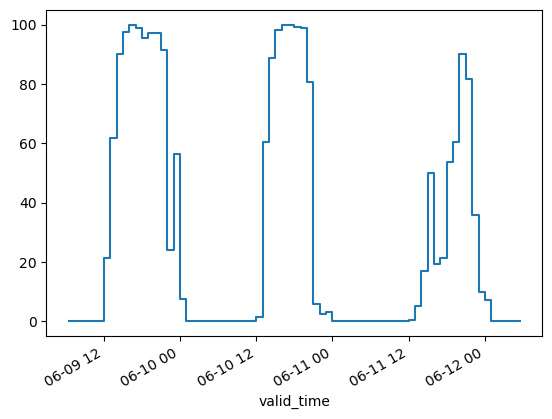

In [8]:
power_fcasts_gfs, _ = model_pv_power(resource_data_gfs, **plant_data)
power_fcasts_gfs.plot(drawstyle='steps-mid')
plt.show()

Convert to local time and calculate daily totals:

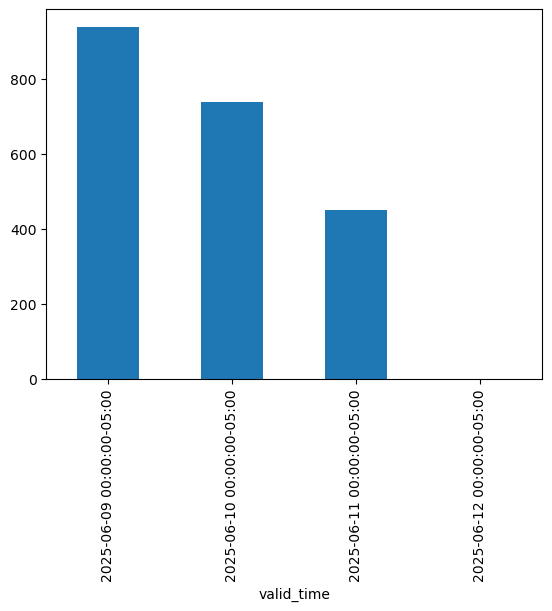

In [9]:
power_fcasts_gfs = power_fcasts_gfs.tz_convert('US/Central')
power_fcasts_gfs_daily = power_fcasts_gfs.resample('1d').sum()

power_fcasts_gfs_daily.plot(kind='bar')
plt.show()

And pick which day has the lowest energy, or at least let the forecast inform scheduling.

In [10]:
power_fcasts_gfs_daily

valid_time
2025-06-09 00:00:00-05:00    938.750954
2025-06-10 00:00:00-05:00    738.991839
2025-06-11 00:00:00-05:00    451.810500
2025-06-12 00:00:00-05:00      0.000000
Freq: D, dtype: float64

Follow the process outlined in [04_Make_Ensemble_Forecasts.ipynb](04_Make_Ensemble_Forecasts.ipynb) to make an ensemble forecast, and some of the steps in [05_Ensemble_Analysis.ipynb](05_Ensemble_Analysis.ipynb) to analyze it (but leaving out the `week` portion of the analysis). 

Assume IFS takes about 8 hours 40 minutes to be published out to 144h based on spot-checking https://data.ecmwf.int/forecasts/20250603/12z/ifs/0p25/enfo/ (change the date in that URL to sometime in the last 4 days...). Based on [1] and [2], it seems like it should take just under 8 hours, but that doesn't seem to work for me.

Below code uses most recent ensemble (00z, 06z, 12z, or 18z), but note that only the 00z and 12z runs go out beyond 144 hours.

[1] https://confluence.ecmwf.int/display/DAC/Dissemination+schedule
[2] https://www.ecmwf.int/en/forecasts/datasets/open-data

In [11]:
delay_to_first_forecast = '520min' # assume IFS takes about 8 hr 40 min from initilization time

time_now = pd.Timestamp.utcnow().tz_localize(None) # current time in UTC, but remove timezone awareness
time_now_offset = time_now - pd.Timedelta(delay_to_first_forecast)

init_date = time_now_offset.floor('6h') # IFS ensemble available every 6 hours
print(init_date)

first_valid_time = time_now.ceil('1d') + pd.Timedelta('6h') # 6:00 UTC tomorrow
print(first_valid_time)

lead_time_to_start = int(round((first_valid_time - init_date).total_seconds() / 3600))
print(lead_time_to_start)

2025-06-08 06:00:00
2025-06-09 06:00:00
24


In [12]:
resource_data_ens = get_solar_forecast_ensemble(
        latitude=plant_data['latitude'],
        longitude=plant_data['longitude'],
        init_date=init_date,
        run_length=69, # just three days to let this example run faster, drop 3 hours to not wrap to the next day
        lead_time_to_start=lead_time_to_start,
        model='ifs',
        attempts=4,
)

resource_data_ens['albedo'] = 0.2 # fill in albedo data

Exception has occured : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))
Exception has occured : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))
Exception has occured : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


👨🏻‍🏭 Created directory: [C:\Users\willh\data\ifs\20250608]


Model power:

In [13]:
member_list = resource_data_ens['member'].unique()
point_list = resource_data_ens['point'].unique()

# empty lists
ens_temp_list = []

for member in member_list:
    for point in point_list:
        # pull plant data
        plant_data = agg_specs_orig_df[point].to_dict()

        # get the resource forecast for the plant
        resource_fcast_ens = resource_data_ens[(resource_data_ens['point']==point) \
            & (resource_data_ens['member']==member)]
        
        resource_fcast_ens = resource_fcast_ens.reset_index().set_index('valid_time')

        # model power
        power_fcasts_ens, _ = model_pv_power(resource_fcast_ens, **plant_data)

        power_fcasts_ens.name = 'power'

        # convert to dataframe and add 'point' (plant number)
        power_fcasts_ens = power_fcasts_ens.to_frame()
        power_fcasts_ens['point'] = point
        power_fcasts_ens['member'] = member

        ens_temp_list.append(power_fcasts_ens)

power_fcasts_ens_all = pd.concat(ens_temp_list)

# convert to central time
power_fcasts_ens_all = power_fcasts_ens_all.tz_convert('Etc/GMT+5')

Calculate daily energy:

In [14]:
df = power_fcasts_ens_all.copy()

df = df.reset_index().set_index(['point', 'member', 'valid_time'])

df = df.groupby([pd.Grouper(level='point'),
                 pd.Grouper(level='member'), 
                 pd.Grouper(level='valid_time', freq='1D')]
               ).sum()
df = df.rename(columns={'power': 'daily_energy'})
df

daily_energy
point member valid_time                             
0     1      2025-06-09 00:00:00-05:00    713.067897
             2025-06-10 00:00:00-05:00    388.984334
             2025-06-11 00:00:00-05:00    477.594131
      2      2025-06-09 00:00:00-05:00    650.762905
             2025-06-10 00:00:00-05:00    609.084690
...                                              ...
      49     2025-06-10 00:00:00-05:00    533.117877
             2025-06-11 00:00:00-05:00    379.329189
      50     2025-06-09 00:00:00-05:00    764.511658
             2025-06-10 00:00:00-05:00    686.060941
             2025-06-11 00:00:00-05:00    551.871854

[150 rows x 1 columns]

Lowest day counts:

In [15]:
# unstack, group by point and week, find min index, re-stack, reset index
df_fcast = (df
		.unstack(level='member')
		.groupby(level=['point'])
		.idxmin()
		.stack(future_stack=True)
		.reset_index())


# The `daily_energy` column is a list of tuples, containing point, member,
# and day (with minimum energy). We can simply extract that column and turn
# it into a dataframe
df_fcast = pd.DataFrame(list(df_fcast['daily_energy']),
		columns=['point', 'valid_time'])

# then get value_counts()
# from https://note.nkmk.me/en/python-pandas-value-counts/
df_fcast = df_fcast.groupby(['point']).value_counts(dropna=False).to_frame()

df_fcast = df_fcast.rename(columns={'count': 'lowest_day_count'})

df_fcast

lowest_day_count
point valid_time                                 
0     2025-06-11 00:00:00-05:00                40
      2025-06-10 00:00:00-05:00                 9
      2025-06-09 00:00:00-05:00                 1

In [16]:
# fill in days with no counts, if needed
df_fcast = df_fcast.reset_index().set_index('valid_time')
days = df.reset_index()['valid_time'].unique()
df_fcast = df_fcast.reindex(index=days)
df_fcast

,point,lowest_day_count
valid_time,,
2025-06-09 00:00:00-05:00,0,1
2025-06-10 00:00:00-05:00,0,9
2025-06-11 00:00:00-05:00,0,40


And make a plot (similar to plotting in [05_Ensemble_Analysis.ipynb](05_Ensemble_Analysis.ipynb), but without specifying the plant_number/point, since there is only one plant this time).

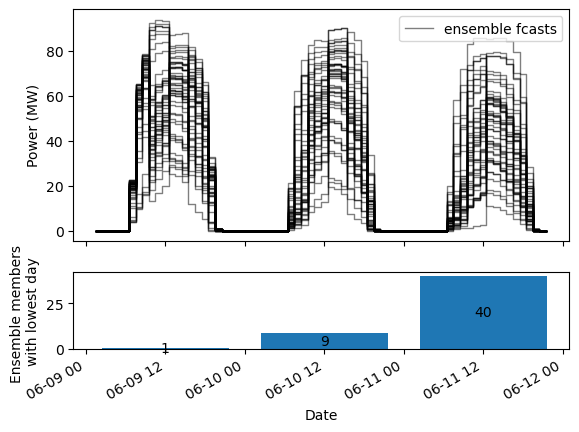

In [17]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(6.4, 5), height_ratios=[3, 1])

startidx=0
endidx=162

plant_number = 0 # use 0 since there is only one plant...
for member in member_list:
    df_temp = power_fcasts_ens_all[(power_fcasts_ens_all['member'] == member)]['power']
    ax1.plot(df_temp.index, df_temp.values, label=('ens mem ' + str(member)), drawstyle='steps-pre', color='k', linewidth=1, alpha=0.5)

ax1.set_ylabel('Power (MW)')
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(['ensemble fcasts'], loc='upper right')

# second subplot
df_temp = df_fcast[df_fcast['point']==plant_number]['lowest_day_count']
df_temp.index = df_temp.index + pd.Timedelta('12h')
labels = df_temp.index.strftime('%Y-%m-%d')

p = ax2.bar(df_temp.index, df_temp.values)

# add labels
ax2.bar_label(p, label_type='center')

ax2.set_xlabel('Date')
ax2.set_ylabel('Ensemble members \nwith lowest day')

fig.autofmt_xdate()